In [5]:
from decimal import Decimal
import json
from decimal import InvalidOperation

objs = []
root = '/Users/rivers/Desktop/nice datasets/MOBA/'
data_root = root+'matches/'
save_root = root+'Topics/Bursty/intermediate/'
graph_root = root+'Topics/Bursty/results/'
game_mode = -1

mode_dict = {-1: 'captainrank', 22: 'rank',1:'allpick',5:'allrandom'}

# Custom JSON decoder function to convert strings back to Decimal
def decimal_decoder(obj):
    for key, value in obj.items():
        if isinstance(value, str):  # Ensure the value is a string
            try:
                # Attempt to convert strings that look like Decimals back to Decimal objects
                obj[key] = Decimal(value)
            except InvalidOperation:
                pass  # Skip conversion if the value cannot be converted to Decimal
    return obj

# Read the list of dictionaries back from the JSON file
with open(data_root+'%s_matches_2000.json'%(mode_dict[game_mode]), 'r') as file:
    objs = json.load(file, object_hook=decimal_decoder)

In [6]:
def calculate_differences(int_list):
    # Ensure the list has at least 2 elements
    if len(int_list) < 2:
        raise ValueError("The list must contain at least 2 elements.")

    # Calculate the differences between consecutive elements
    differences = [int_list[i+1] - int_list[i] for i in range(len(int_list) - 1)]
    
    return differences

def chats_of(slot,chat):
    t = []
    l = []
    for chat_line in chat:
        #print(chat_line)
        if 'slot' in list(chat_line.keys()):
            if chat_line['slot'] == slot:
                t.append(chat_line['time'])
                l.append(len(str(chat_line['key'])))
    if len(t) > 1:
        t_diff = calculate_differences(t)
        t_diff.insert(0,0)
    
        return l, t_diff
    else:
        return [],[]


In [3]:
# Team 

modes = list(mode_dict.keys())
slots = list(range(10))

team_t, team_l, ind_t, ind_l= {}, {}, {}, {}

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:

        objs = json.load(file, object_hook=decimal_decoder)

        
    team_t_sample, team_l_sample, ind_t_sample, ind_l_sample = [], [], [], []
    for obj in objs:
        if (mode == 2 and obj['lobby_type'] == 7) or mode != 2:
            time = []
            if len(obj['chat']) > 1:
                for chat_line in obj['chat']:
                    time.append(chat_line['time'])
                    
                    team_l_sample.append(len(str(chat_line['key'])))
                
                diff = calculate_differences(time)
                diff.insert(0,0)
                team_t_sample += diff
            
            for slot in slots:
                l, t_diff = chats_of(slot, obj['chat'])
                ind_t_sample += t_diff
                ind_l_sample += l
    
    team_t[mode], team_l[mode], ind_l[mode], ind_t[mode] = team_t_sample, team_l_sample, ind_l_sample, ind_t_sample


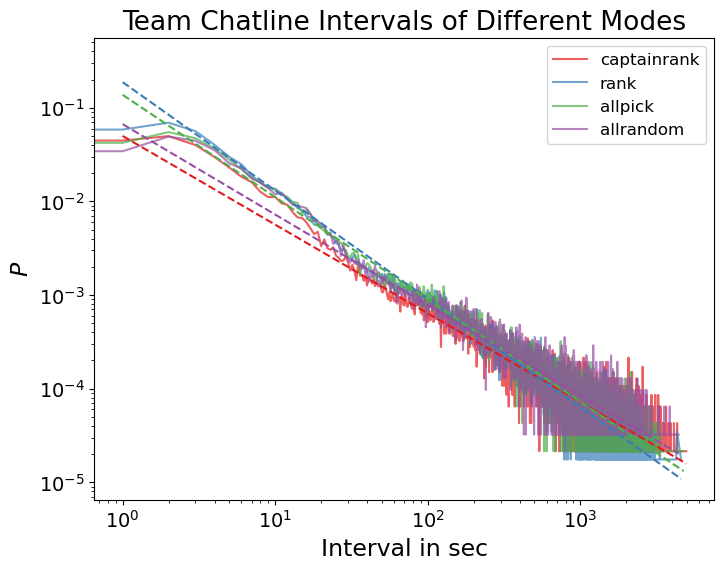

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Define color palette
palette = sns.color_palette("Set1")

# Dictionary to store processed data
ind = {}
t = ind_t # ind_t/ team_t
# Process each mode's t_sample in ind_t
for i, mode in enumerate(t.keys()):  
    dist = Counter(t[mode])  # Count occurrences in the current sample
    x, y = [], []
    
    for interval in sorted(dist):   
        x.append(interval)
        y.append(dist[interval] / sum(dist.values()))  # Normalize using total count
    
    ind[mode] = (x, y)  # Store in dictionary

# Plot raw data
plt.figure(figsize=(8, 6))
for i, (mode, (x, y)) in enumerate(ind.items()):
    plt.plot(x, y, label=mode_dict[mode], color=palette[i], alpha=0.7)

# Fit power-law lines
for i, (mode, (x, y)) in enumerate(ind.items()):
    x = np.array(x)
    y = np.array(y)
    
    # Avoid log issues by replacing zeros
    x = np.where(x == 0, 1, x)
    y = np.where(y == 0, 1, y)

    # Fit a power-law in log-log space
    coeffs = np.polyfit(np.log(x), np.log(y), 1)
    fitted_line = np.exp(coeffs[1]) * x ** coeffs[0]

    # Plot fitted line
    plt.plot(x, fitted_line, linestyle='--', color=palette[i])

# Labels, scales, and legend
plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P$', fontsize=17)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Team Chatline Intervals of Different Modes', fontsize=19)
plt.legend(fontsize=12)

# Save and show plot
# plt.savefig(graph_root+'team_power_law_fit.pdf')
plt.show()

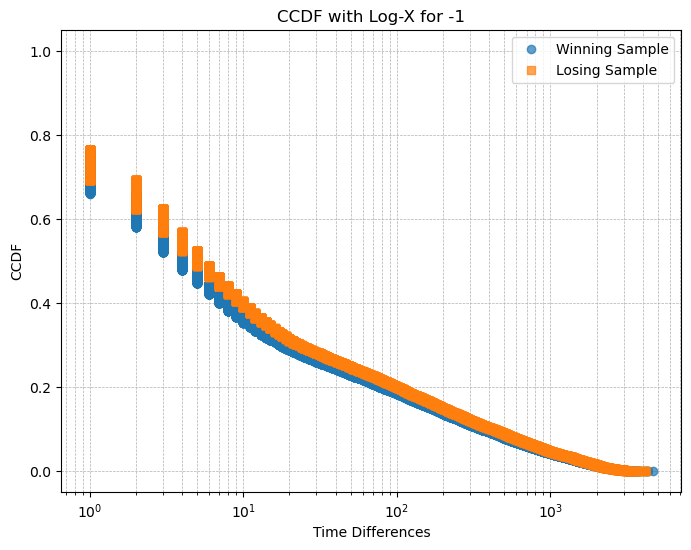

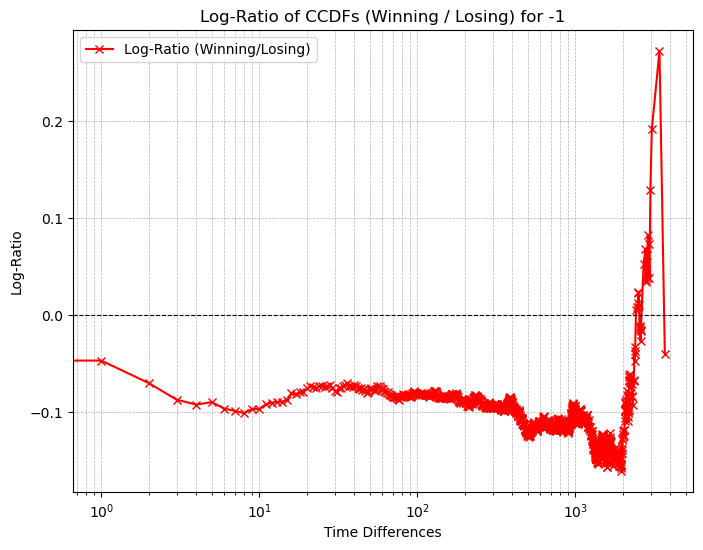

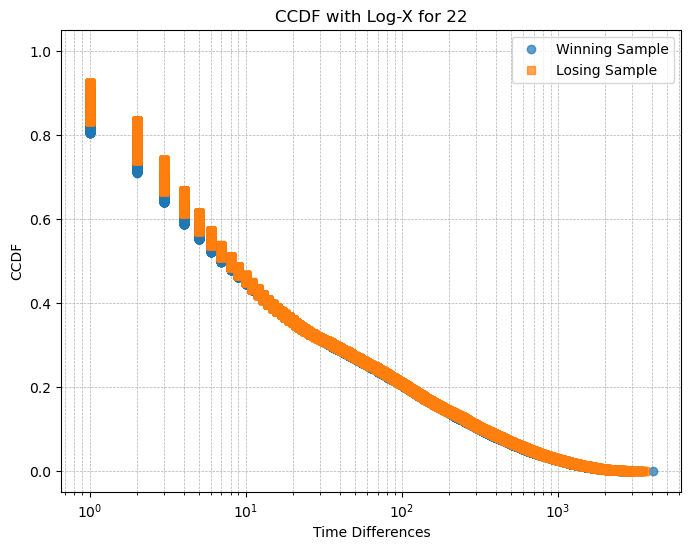

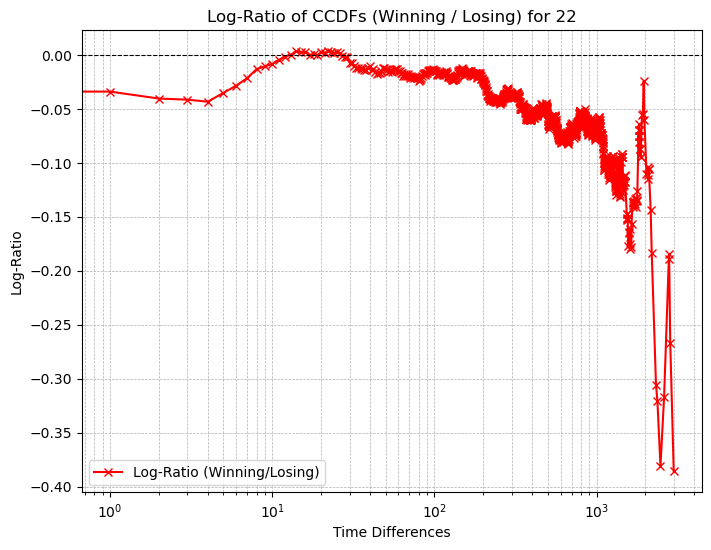

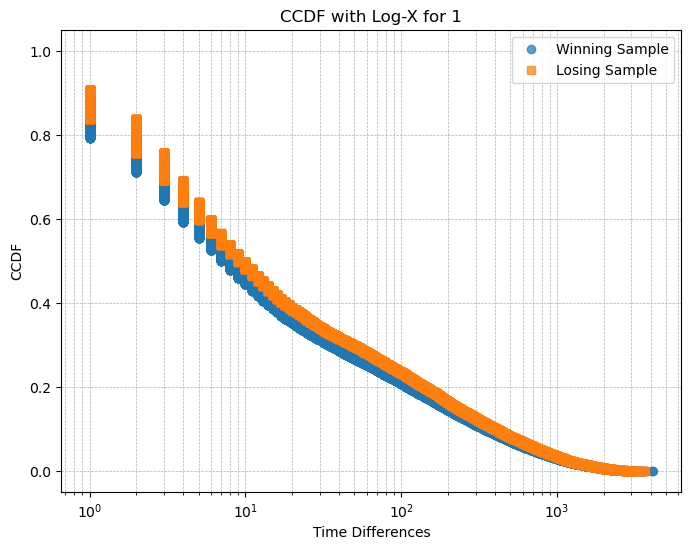

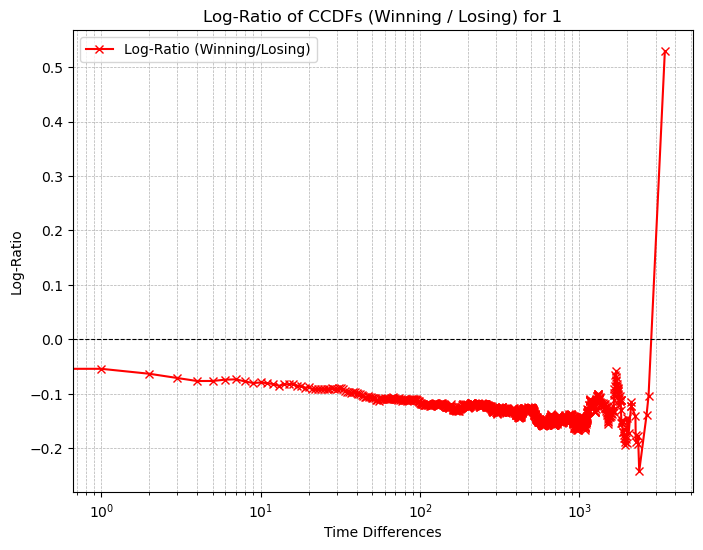

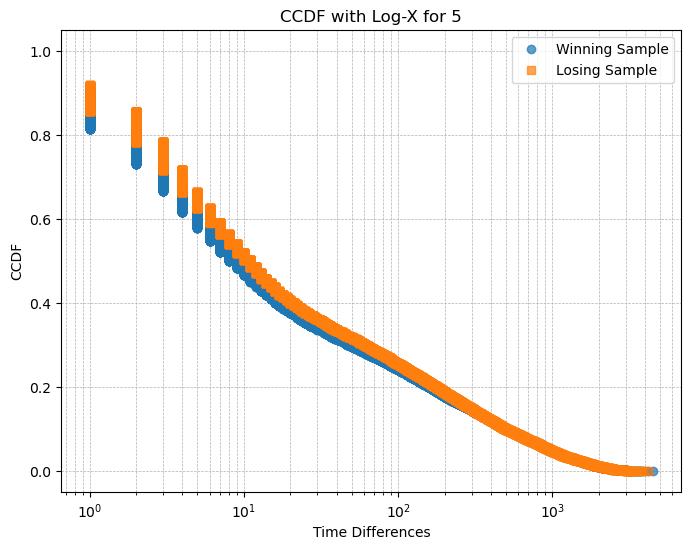

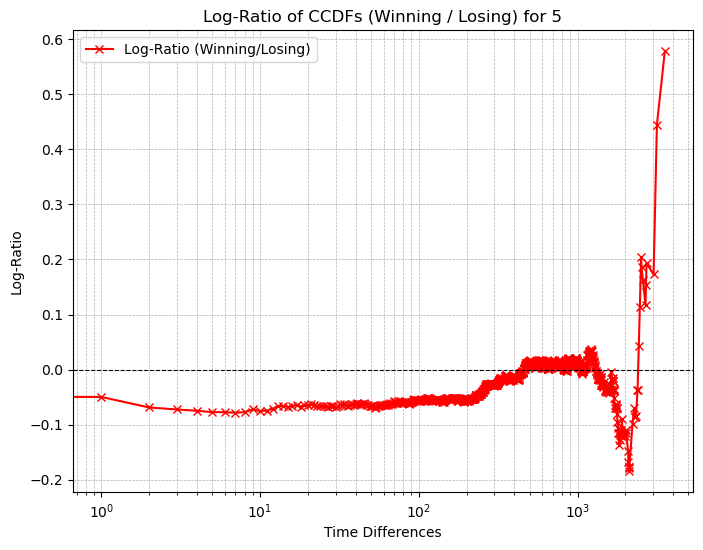

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt

radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]

def calculate_differences(times):
    return np.diff(sorted(times))

def compute_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf

def compute_log_ratio(ccdf_win, ccdf_lose):
    return np.log(ccdf_win / ccdf_lose)

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)
    
    winning_sample = []
    losing_sample = []
    
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        
        if len(obj['chat']) > 1:
            for chat in obj['chat']:
                if 'slot' in chat:
                    if (chat['slot'] in radiant and obj['radiant_win']) or (chat['slot'] in dire and not obj['radiant_win']):
                        winning_team_t.append(chat['time'])
                    else:
                        losing_team_t.append(chat['time'])
            
            if len(winning_team_t) > 1:
                winning_sample += list(calculate_differences(winning_team_t))
            if len(losing_team_t) > 1:
                losing_sample += list(calculate_differences(losing_team_t))
    
    # Compute CCDF
    if winning_sample and losing_sample:
        win_x, win_ccdf = compute_ccdf(winning_sample)
        lose_x, lose_ccdf = compute_ccdf(losing_sample)
        
        # Ensure both CCDFs have values at the same x points
        common_x = np.intersect1d(win_x, lose_x)
        win_ccdf_interp = np.interp(common_x, win_x, win_ccdf)
        lose_ccdf_interp = np.interp(common_x, lose_x, lose_ccdf)
        
        log_ratio = compute_log_ratio(win_ccdf_interp, lose_ccdf_interp)
        
        # Plot CCDF with log-x and linear-y axis
        plt.figure(figsize=(8, 6))
        plt.semilogx(win_x, win_ccdf, marker='o', linestyle='none', label='Winning Sample', alpha=0.7)
        plt.semilogx(lose_x, lose_ccdf, marker='s', linestyle='none', label='Losing Sample', alpha=0.7)
    
        plt.xlabel('Time Differences')
        plt.ylabel('CCDF')
        plt.legend()
        plt.title(f'CCDF with Log-X for {mode}')
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.show()
        
        # Plot log-ratio
        plt.figure(figsize=(8, 6))
        plt.semilogx(common_x, log_ratio, marker='x', linestyle='-', color='r', label='Log-Ratio (Winning/Losing)')
        plt.xlabel('Time Differences')
        plt.ylabel('Log-Ratio')
        plt.title(f'Log-Ratio of CCDFs (Winning / Losing) for {mode}')
        plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
        plt.legend()
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.show()

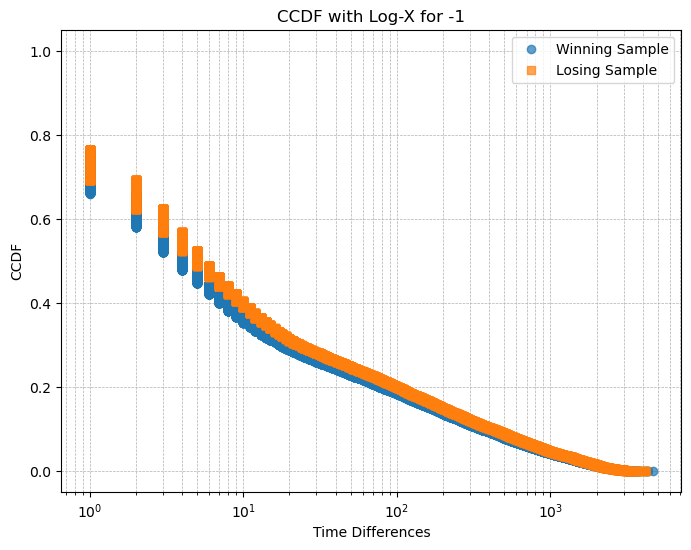

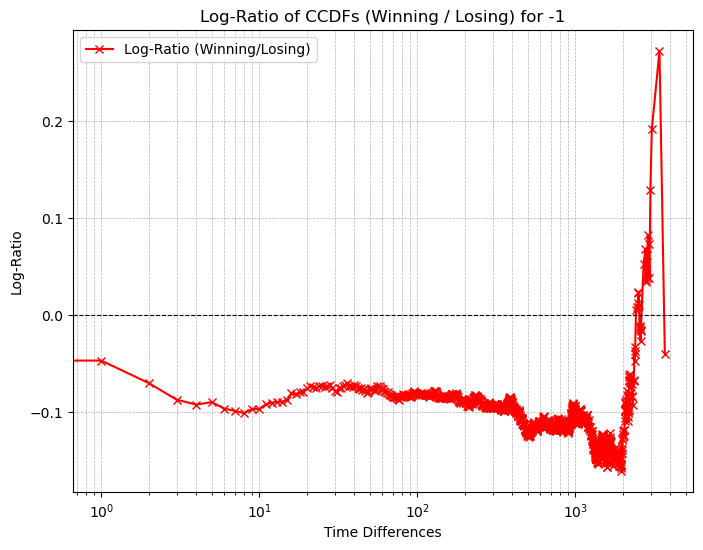

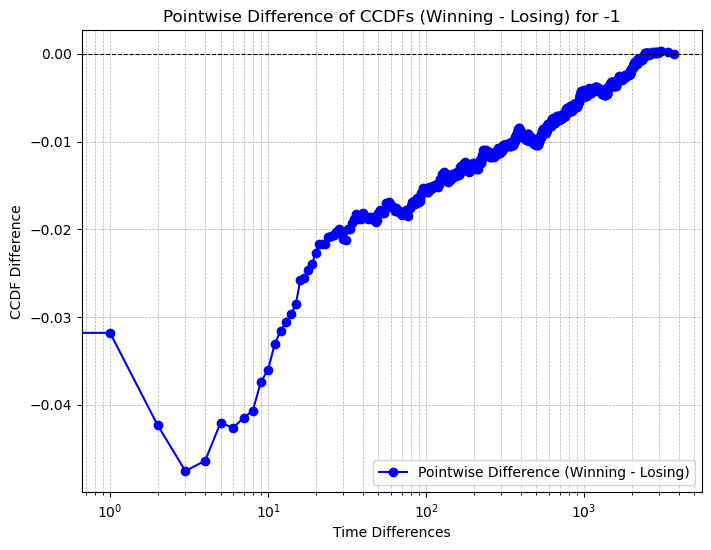

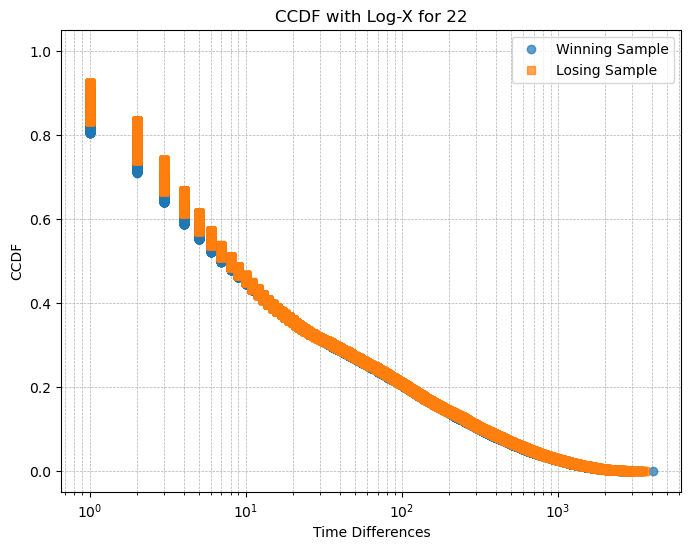

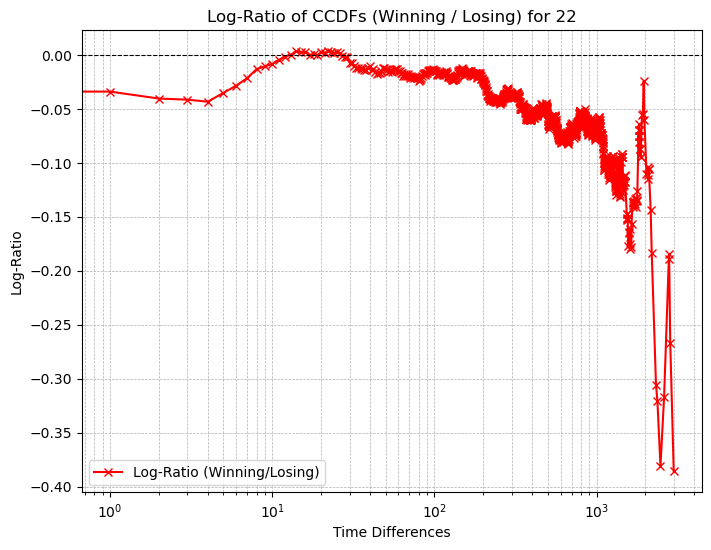

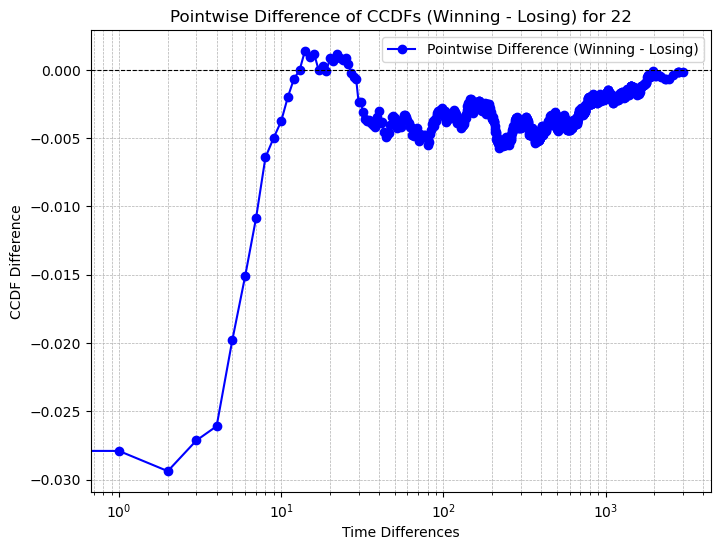

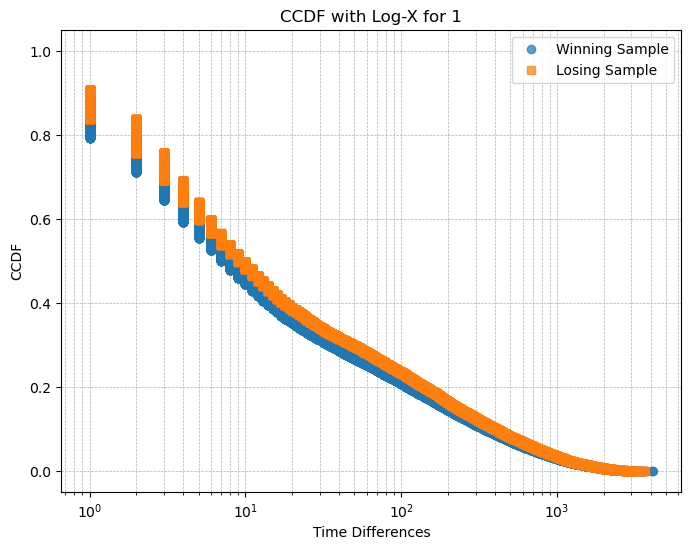

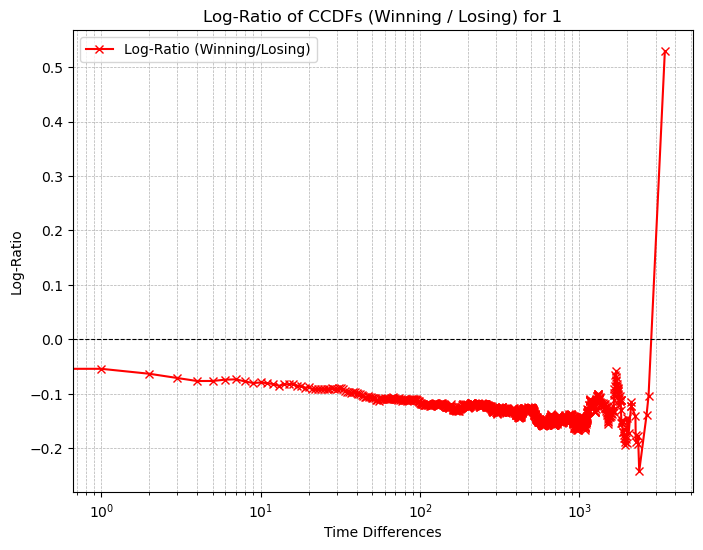

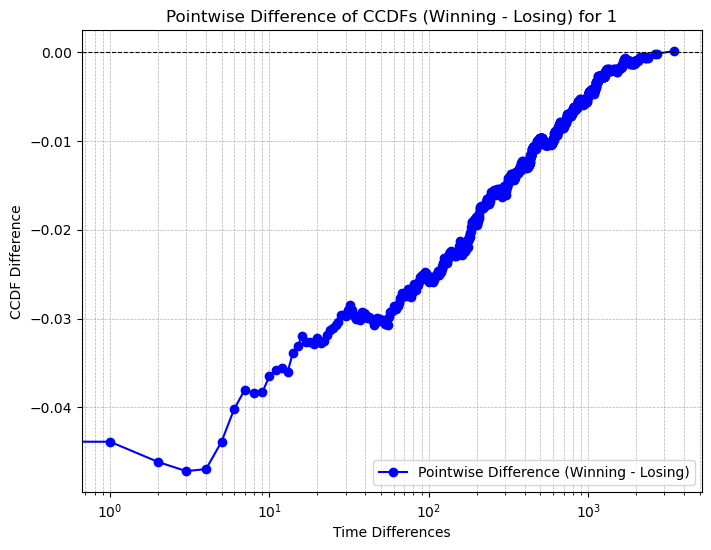

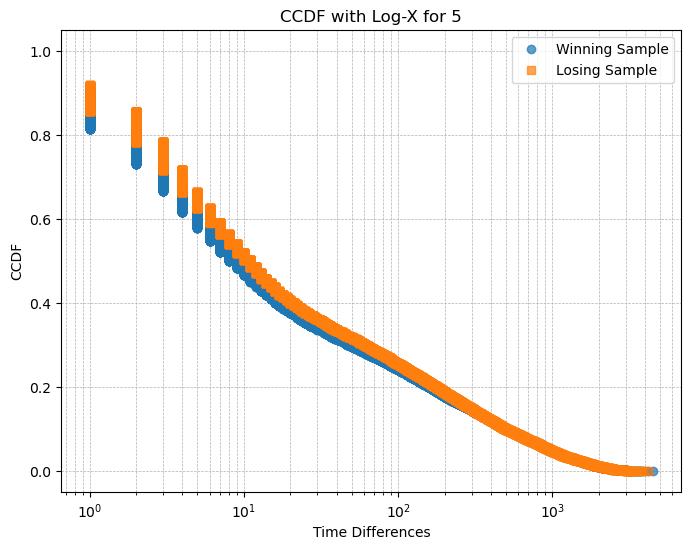

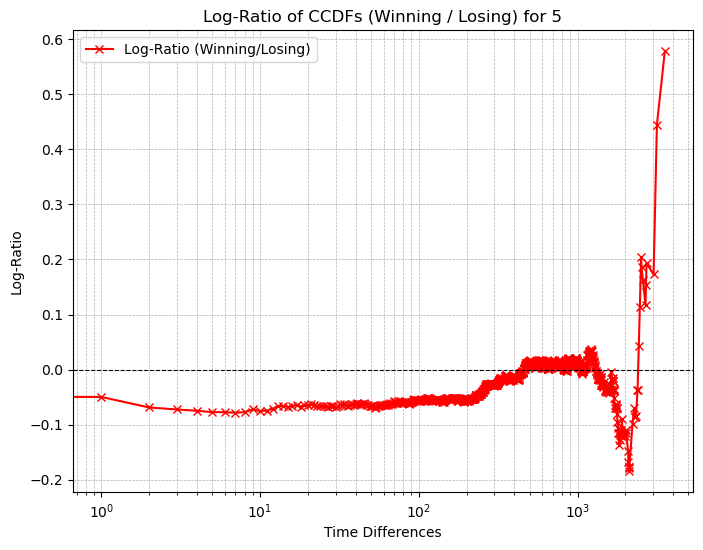

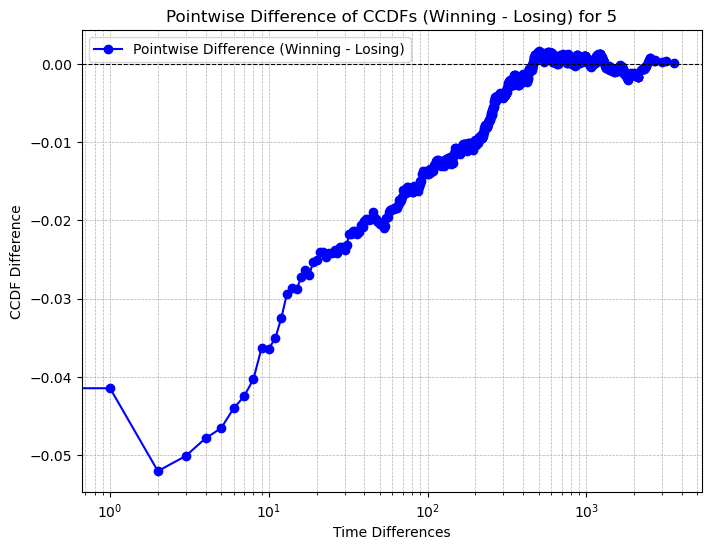

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt

radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]

def calculate_differences(times):
    return np.diff(sorted(times))

def compute_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf

def compute_log_ratio(ccdf_win, ccdf_lose):
    return np.log(ccdf_win / ccdf_lose)

def compute_pointwise_difference(ccdf_win, ccdf_lose):
    return ccdf_win - ccdf_lose

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)
    
    winning_sample = []
    losing_sample = []
    
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        
        if len(obj['chat']) > 1:
            for chat in obj['chat']:
                if 'slot' in chat:
                    if (chat['slot'] in radiant and obj['radiant_win']) or (chat['slot'] in dire and not obj['radiant_win']):
                        winning_team_t.append(chat['time'])
                    else:
                        losing_team_t.append(chat['time'])
            
            if len(winning_team_t) > 1:
                winning_sample += list(calculate_differences(winning_team_t))
            if len(losing_team_t) > 1:
                losing_sample += list(calculate_differences(losing_team_t))
    
    # Compute CCDF
    if winning_sample and losing_sample:
        win_x, win_ccdf = compute_ccdf(winning_sample)
        lose_x, lose_ccdf = compute_ccdf(losing_sample)
        
        # Ensure both CCDFs have values at the same x points
        common_x = np.intersect1d(win_x, lose_x)
        win_ccdf_interp = np.interp(common_x, win_x, win_ccdf)
        lose_ccdf_interp = np.interp(common_x, lose_x, lose_ccdf)
        
        log_ratio = compute_log_ratio(win_ccdf_interp, lose_ccdf_interp)
        pointwise_diff = compute_pointwise_difference(win_ccdf_interp, lose_ccdf_interp)
        
        # Plot CCDF with log-x and linear-y axis
        plt.figure(figsize=(8, 6))
        plt.semilogx(win_x, win_ccdf, marker='o', linestyle='none', label='Winning Sample', alpha=0.7)
        plt.semilogx(lose_x, lose_ccdf, marker='s', linestyle='none', label='Losing Sample', alpha=0.7)
    
        plt.xlabel('Time Differences')
        plt.ylabel('CCDF')
        plt.legend()
        plt.title(f'CCDF with Log-X for {mode}')
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.show()
        
        # Plot log-ratio
        plt.figure(figsize=(8, 6))
        plt.semilogx(common_x, log_ratio, marker='x', linestyle='-', color='r', label='Log-Ratio (Winning/Losing)')
        plt.xlabel('Time Differences')
        plt.ylabel('Log-Ratio')
        plt.title(f'Log-Ratio of CCDFs (Winning / Losing) for {mode}')
        plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
        plt.legend()
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.show()
        
        # Plot pointwise difference
        plt.figure(figsize=(8, 6))
        plt.semilogx(common_x, pointwise_diff, marker='o', linestyle='-', color='b', label='Pointwise Difference (Winning - Losing)')
        plt.xlabel('Time Differences')
        plt.ylabel('CCDF Difference')
        plt.title(f'Pointwise Difference of CCDFs (Winning - Losing) for {mode}')
        plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
        plt.legend()
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.show()


In [39]:
import powerlaw
data = team_t[-1]  # Your dataset
fit = powerlaw.Fit(data, xmax = 100)

alpha = fit.alpha
xmin = fit.xmin
print(f"Power-law exponent: {alpha}, xmin: {xmin}")

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Power-law exponent: 2.0002339971131735, xmin: 4.0


/opt/anaconda3/lib/python3.11/site-packages/powerlaw.py:1188: RuntimeWarning: overflow encountered in scalar power
  return (self.alpha-1) * self.xmin**(self.alpha-1)
/opt/anaconda3/lib/python3.11/site-packages/powerlaw.py:835: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C


In [38]:
fit.xmin

2871.0

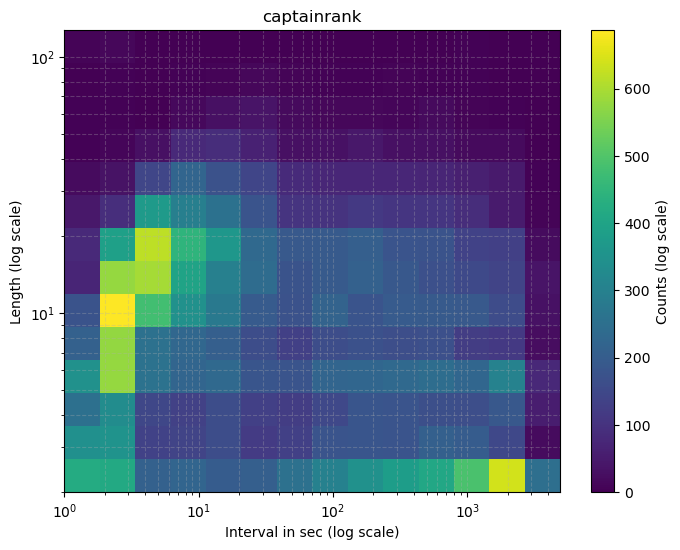

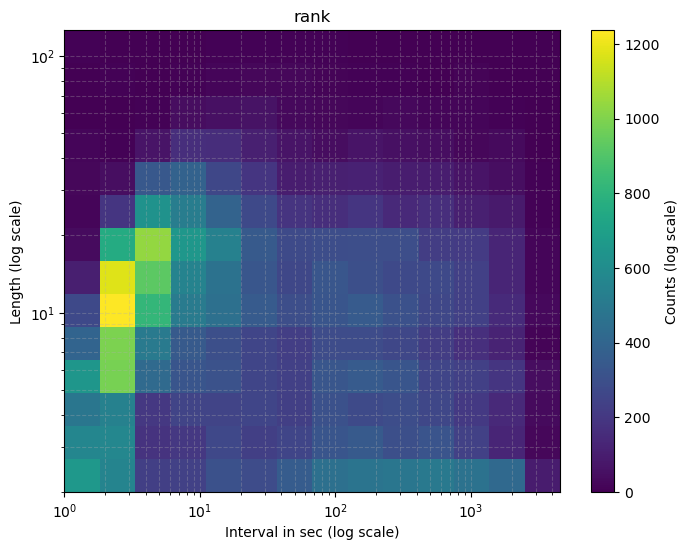

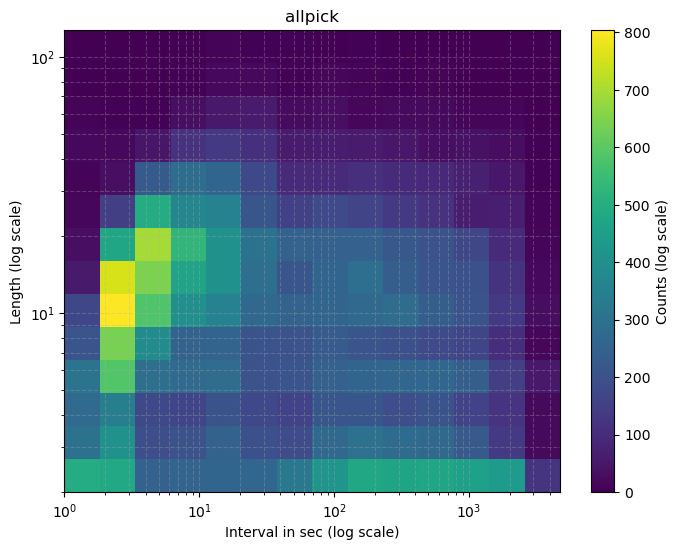

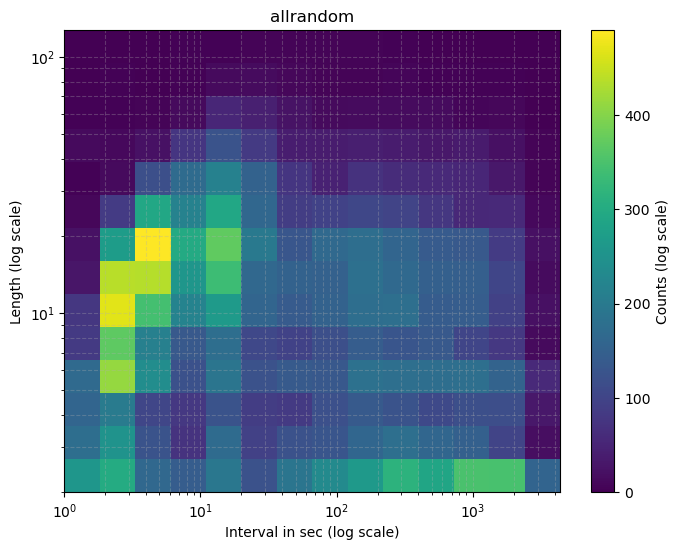

In [ ]:
import matplotlib.colors as mcolors
import numpy as np
for mode in modes:

    t_sample = ind_t[mode]
    l_sample = ind_l[mode]
    x_bins = np.logspace(np.log10(min(t_sample) + 1), np.log10(max(t_sample)), 15)
    y_bins = np.logspace(np.log10(min(l_sample) + 1), np.log10(max(l_sample)), 15)

    # Create 2D histogram data
    heatmap, xedges, yedges = np.histogram2d(t_sample, l_sample, bins=[x_bins, y_bins])

    # Plot the heatmap with a logarithmic color scale
    plt.figure(figsize=(8, 6))

    #bounds = np.linspace(0, 1000, 200)
    #norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

    plt.pcolormesh(
        xedges, yedges, heatmap.T, shading='auto', cmap='viridis',
      #  norm=mcolors.LogNorm(vmin=1, vmax=3000)
    )
    plt.colorbar(label='Counts (log scale)')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Length (log scale)')
    plt.xlabel('Interval in sec (log scale)')
    plt.title(mode_dict[(mode)])
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.savefig(graph_root+'/heatmap_ind_tVl_%s.pdf'%(mode_dict[mode]))
    plt.show()

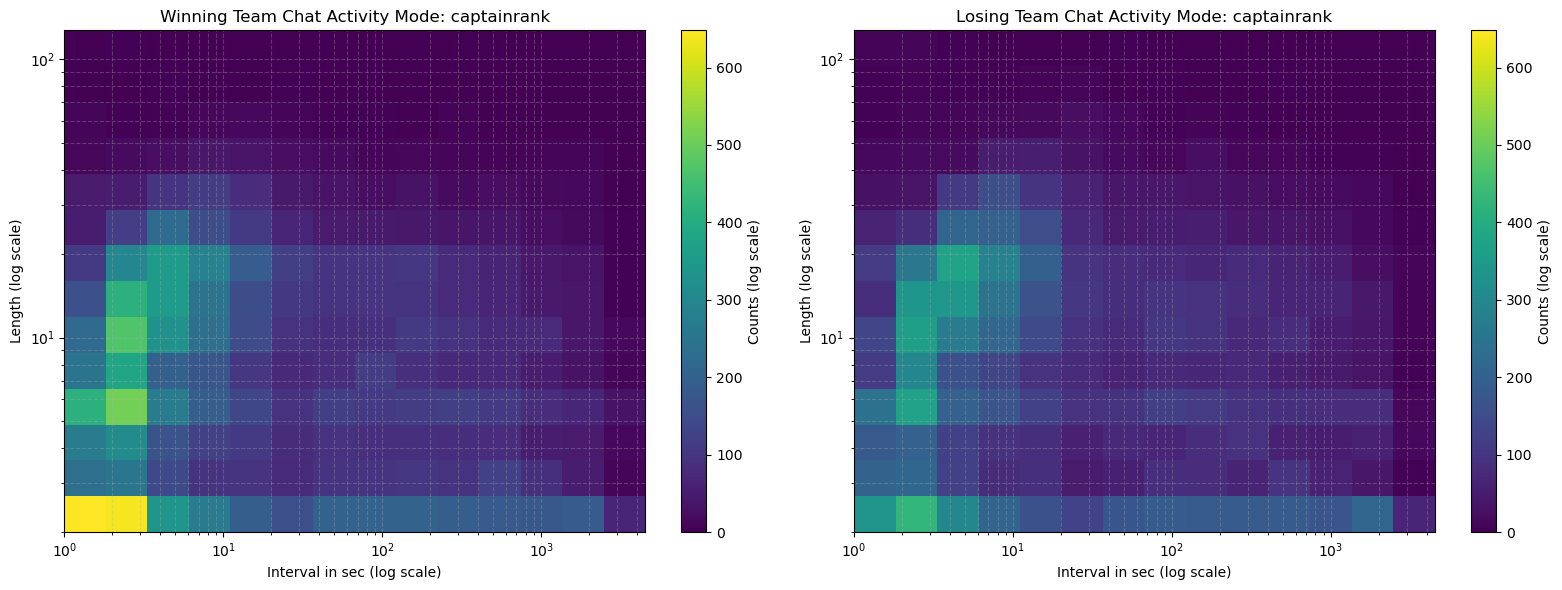

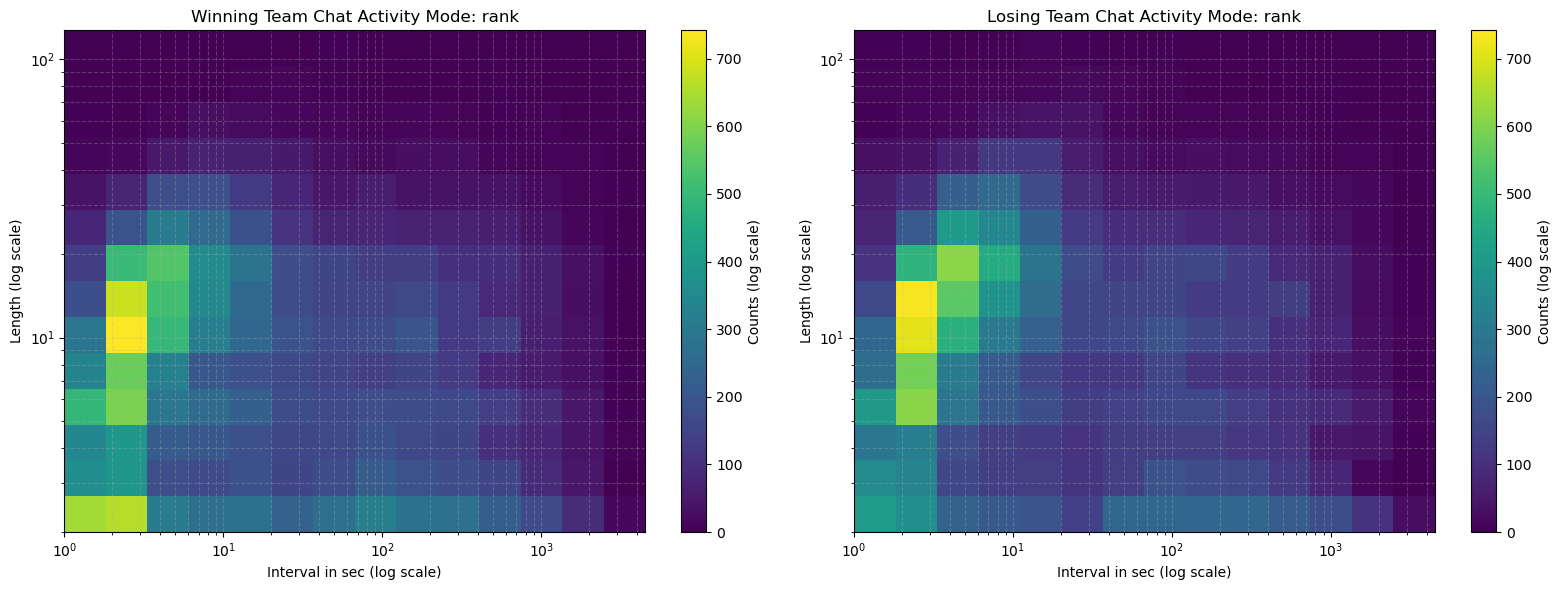

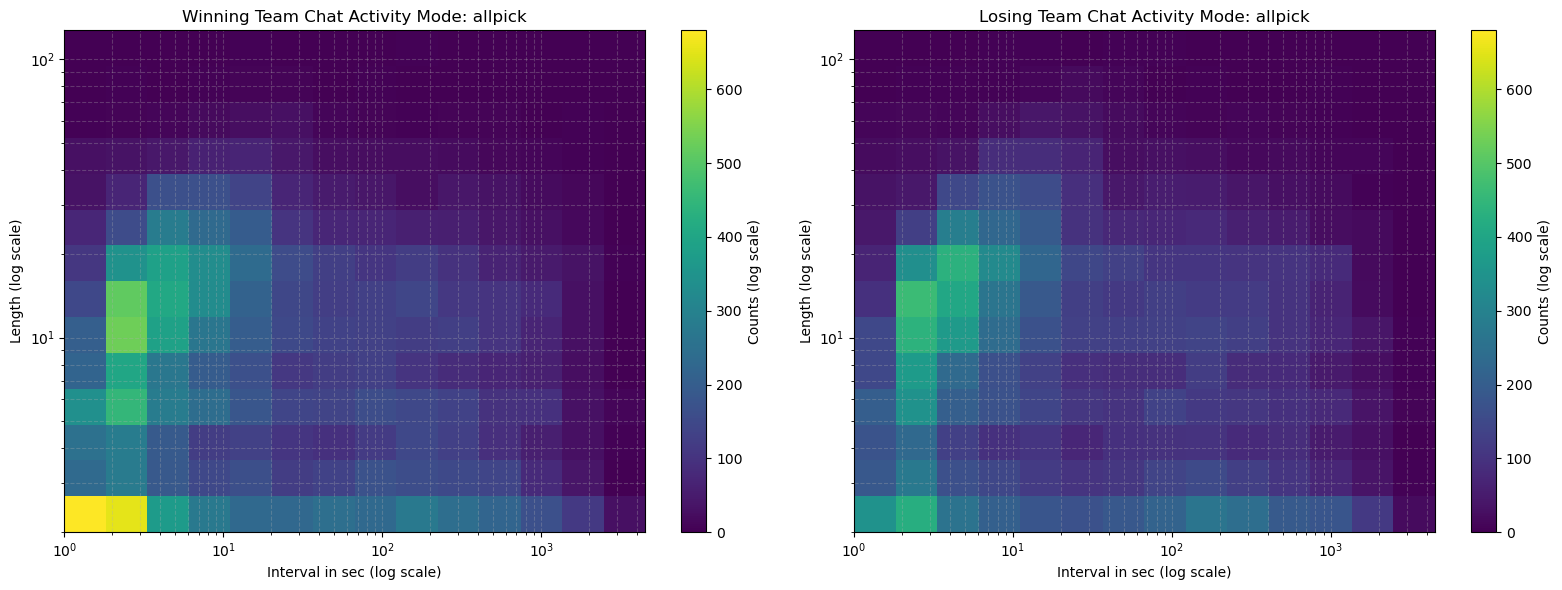

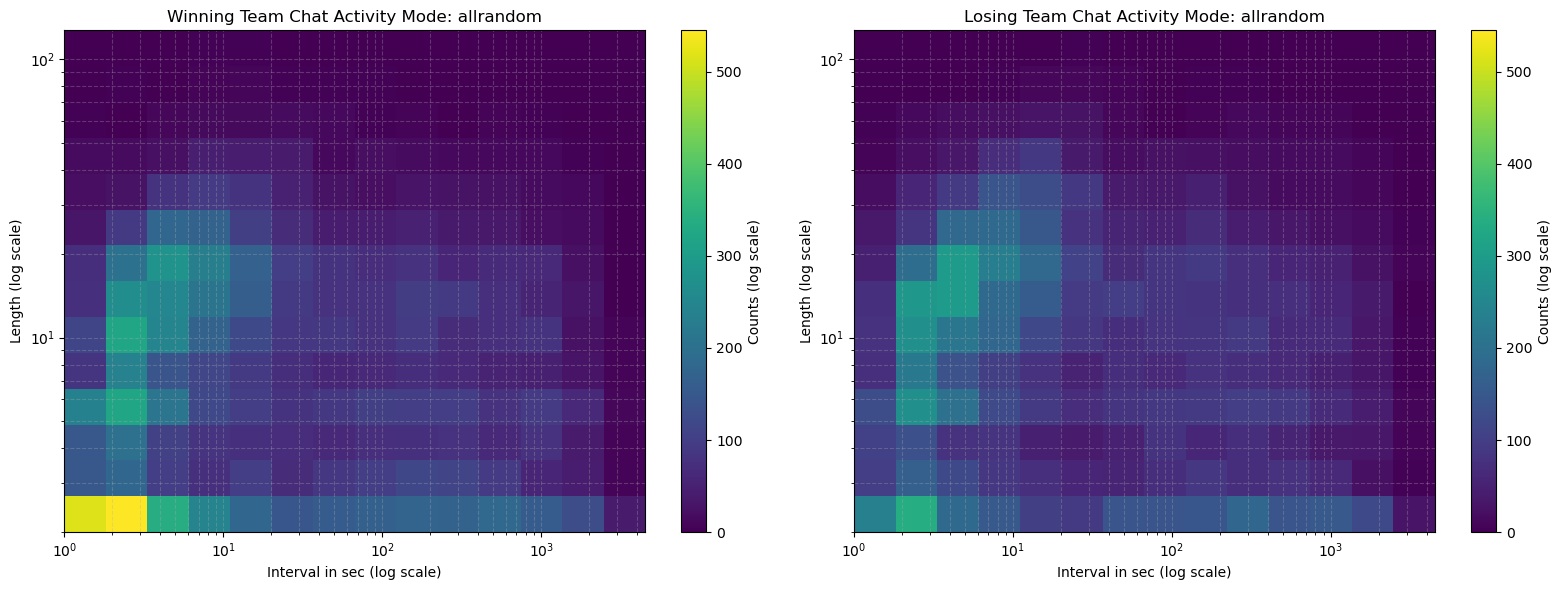

In [31]:
radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]
# count = 0

# winning_L = []
# losing_L = []

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:

        objs = json.load(file, object_hook=decimal_decoder)
    
    winning_sample = []
    losing_sample = []
    winning_L = []
    losing_L = []
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        wining_diff = []
        losing_diff = []
        w, l = True, True
        if len(obj['chat']) > 1:
            
            for chat in obj['chat']:
                if 'slot' in list(chat.keys()):
                    if (chat['slot'] in radiant and obj['radiant_win']==True) or (chat['slot'] in dire and obj['radiant_win']==False):
                        winning_team_t.append(chat['time'])
                        # print('here')
                        if w == False:
                            winning_L.append(len(str(chat['key'])))
                        w = False
                    else:
                        losing_team_t.append(chat['time'])
                        if l == False:
                            losing_L.append(len(str(chat['key'])))
                        l = False
                    if len(winning_team_t)>1:
                        wining_diff = calculate_differences(winning_team_t)
                    if len(losing_team_t)>1:
                        losing_diff = calculate_differences(losing_team_t)
                count+=1
        winning_sample += wining_diff
        losing_sample += losing_diff
    
    # Compute histograms
    winning_heatmap, _, _ = np.histogram2d(winning_sample, winning_L, bins=[x_bins, y_bins])
    losing_heatmap, _, _ = np.histogram2d(losing_sample, losing_L, bins=[x_bins, y_bins])
    lim = np.max([np.max(winning_heatmap), np.max(losing_heatmap)])
    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Winning team heatmap
    ax = axes[0]
    cax = ax.pcolormesh(x_bins, y_bins, winning_heatmap.T, shading='auto', cmap='viridis', norm=mcolors.Normalize(vmax=lim))
    fig.colorbar(cax, ax=ax, label='Counts (log scale)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Interval in sec (log scale)')
    ax.set_ylabel('Length (log scale)')
    ax.set_title('Winning Team Chat Activity Mode: %s'%mode_dict[mode])
    ax.grid(True, which='both', linestyle='--', alpha=0.3)

    # Losing team heatmap
    ax = axes[1]
    cax = ax.pcolormesh(x_bins, y_bins, losing_heatmap.T, shading='auto', cmap='viridis',norm=mcolors.Normalize(vmax=lim))
    fig.colorbar(cax, ax=ax, label='Counts (log scale)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Interval in sec (log scale)')
    ax.set_ylabel('Length (log scale)')
    ax.set_title('Losing Team Chat Activity Mode: %s'%mode_dict[mode])
    ax.grid(True, which='both', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.savefig(graph_root+'/heatmap_won&lost_tVl_%s.pdf'%(mode_dict[mode]))
    plt.show()

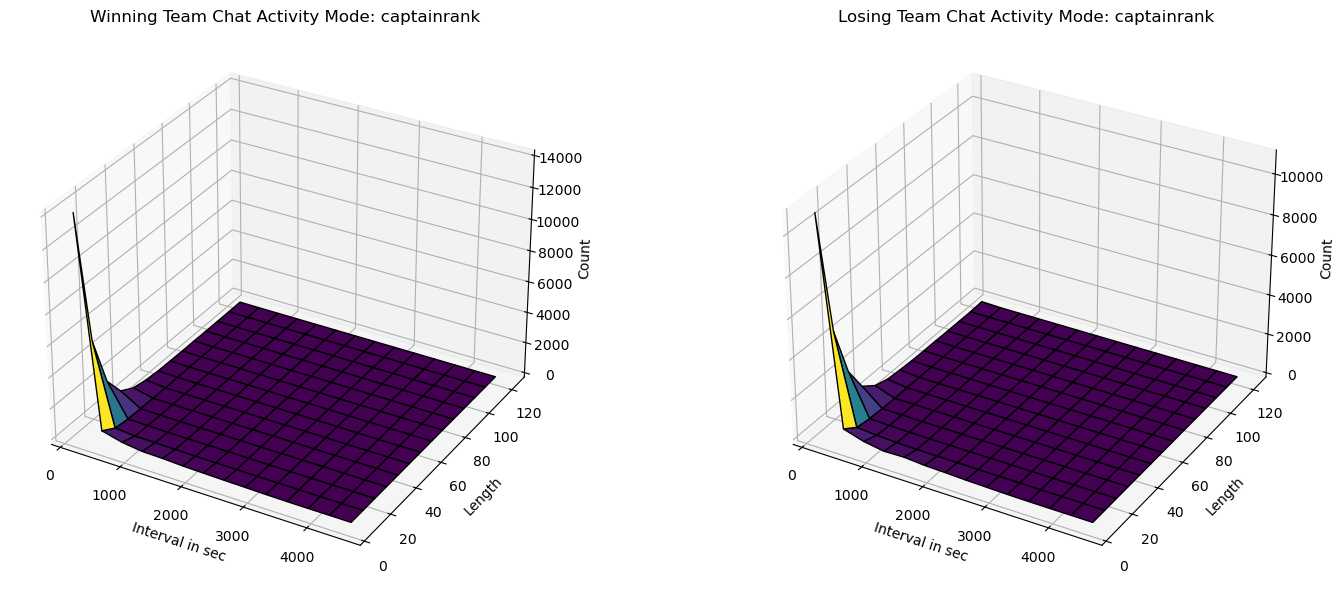

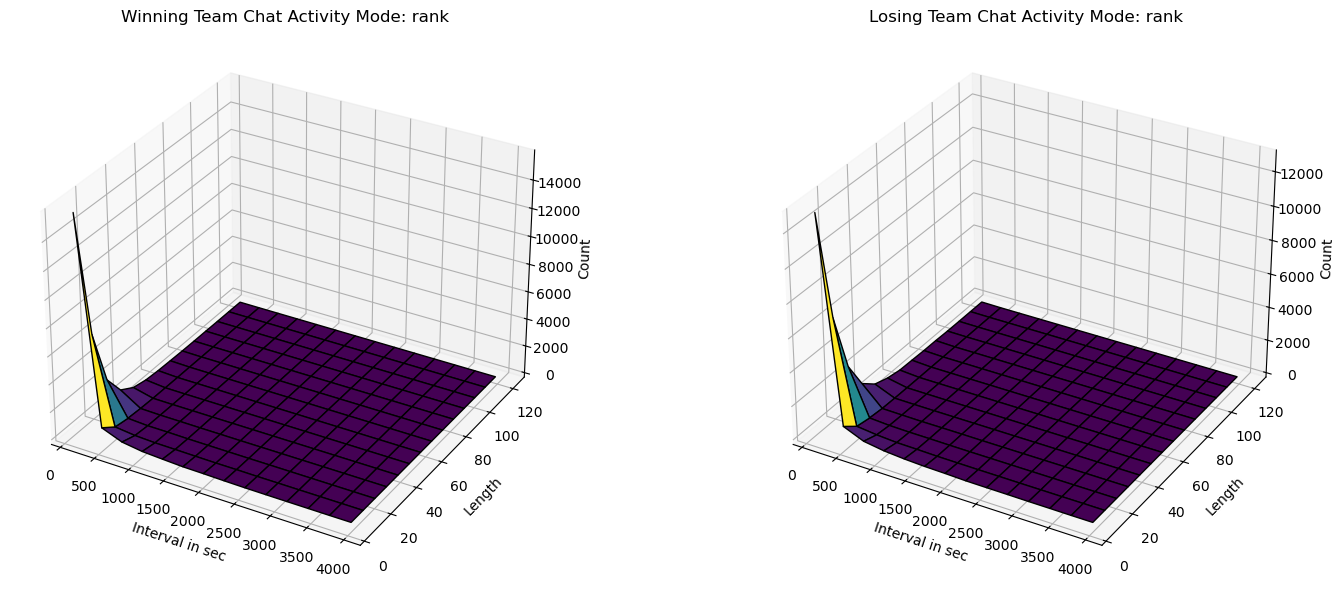

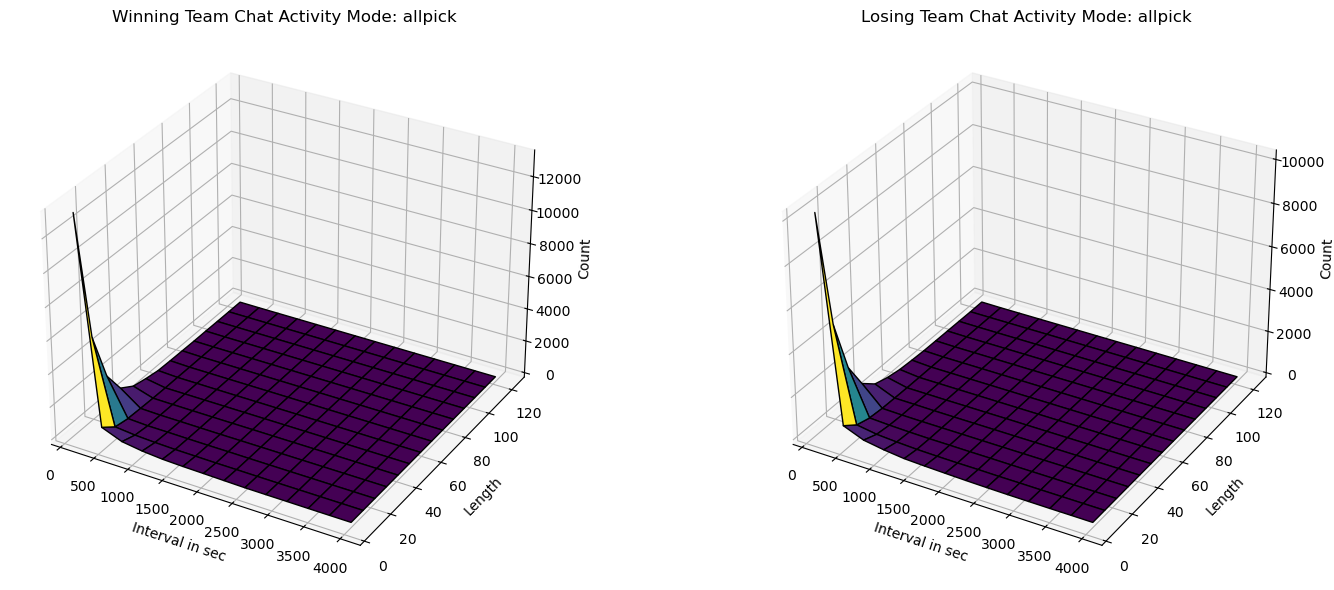

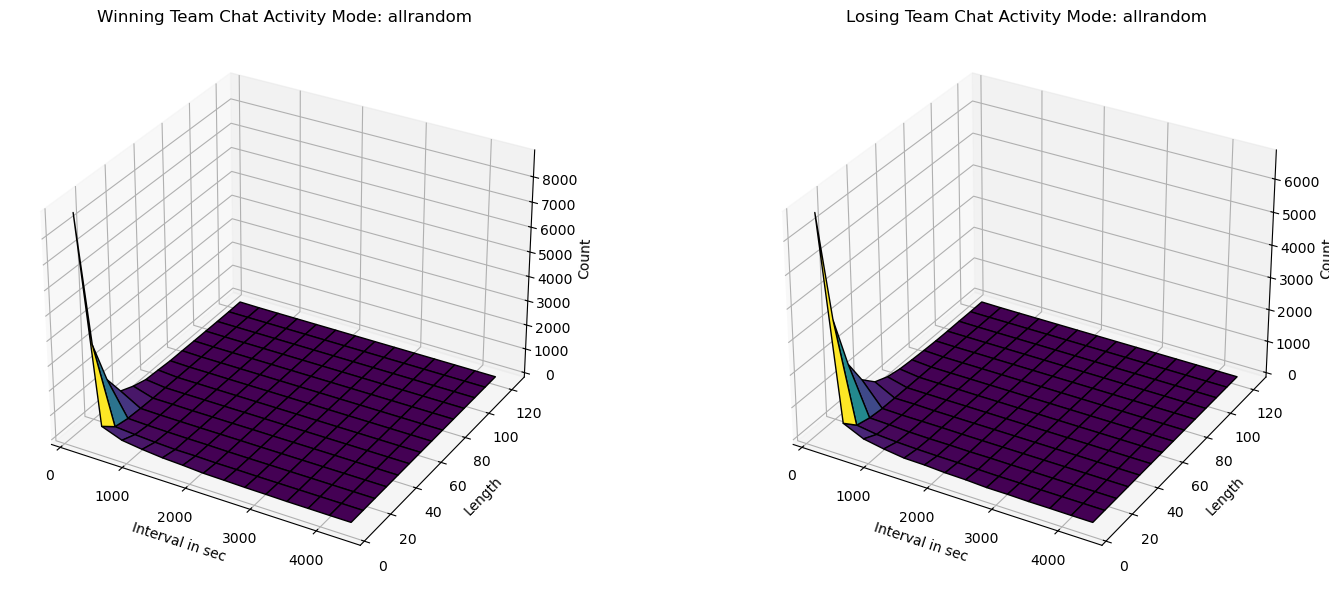

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)
    
    winning_sample = []
    losing_sample = []
    winning_L = []
    losing_L = []
    
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        wining_diff = []
        losing_diff = []
        w, l = True, True
        
        if len(obj['chat']) > 1:
            for chat in obj['chat']:
                if 'slot' in chat:
                    if (chat['slot'] in radiant and obj['radiant_win']) or (chat['slot'] in dire and not obj['radiant_win']):
                        winning_team_t.append(chat['time'])
                        if not w:
                            winning_L.append(len(str(chat['key'])))
                        w = False
                    else:
                        losing_team_t.append(chat['time'])
                        if not l:
                            losing_L.append(len(str(chat['key'])))
                        l = False
            
            if len(winning_team_t) > 1:
                wining_diff = calculate_differences(winning_team_t)
            if len(losing_team_t) > 1:
                losing_diff = calculate_differences(losing_team_t)
        
        winning_sample += wining_diff
        losing_sample += losing_diff
    
    # Compute histograms
    x_bins = np.linspace(min(winning_sample + losing_sample), max(winning_sample + losing_sample), 15)
    y_bins = np.linspace(min(winning_L + losing_L), max(winning_L + losing_L), 15)
    
    winning_heatmap, xedges, yedges = np.histogram2d(winning_sample, winning_L, bins=[x_bins, y_bins])
    losing_heatmap, _, _ = np.histogram2d(losing_sample, losing_L, bins=[x_bins, y_bins])
    
    lim = np.max([np.max(winning_heatmap), np.max(losing_heatmap)])
    
    # Create meshgrid for 3D plotting
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    
    fig = plt.figure(figsize=(16, 6))
    
    # Winning team 3D PMF
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, winning_heatmap.T, cmap='viridis', edgecolor='k')
    ax.set_xlabel('Interval in sec')
    ax.set_ylabel('Length')
    ax.set_zlabel('Count')
    ax.set_title('Winning Team Chat Activity Mode: %s' % mode_dict[mode])
    
    # Losing team 3D PMF
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(X, Y, losing_heatmap.T, cmap='viridis', edgecolor='k')
    ax.set_xlabel('Interval in sec')
    ax.set_ylabel('Length')
    ax.set_zlabel('Count')
    ax.set_title('Losing Team Chat Activity Mode: %s' % mode_dict[mode])
    
    plt.tight_layout()
   # plt.savefig(graph_root+'/3D_pmf_won&lost_tVl_%s.pdf' % mode_dict[mode])
    plt.show()

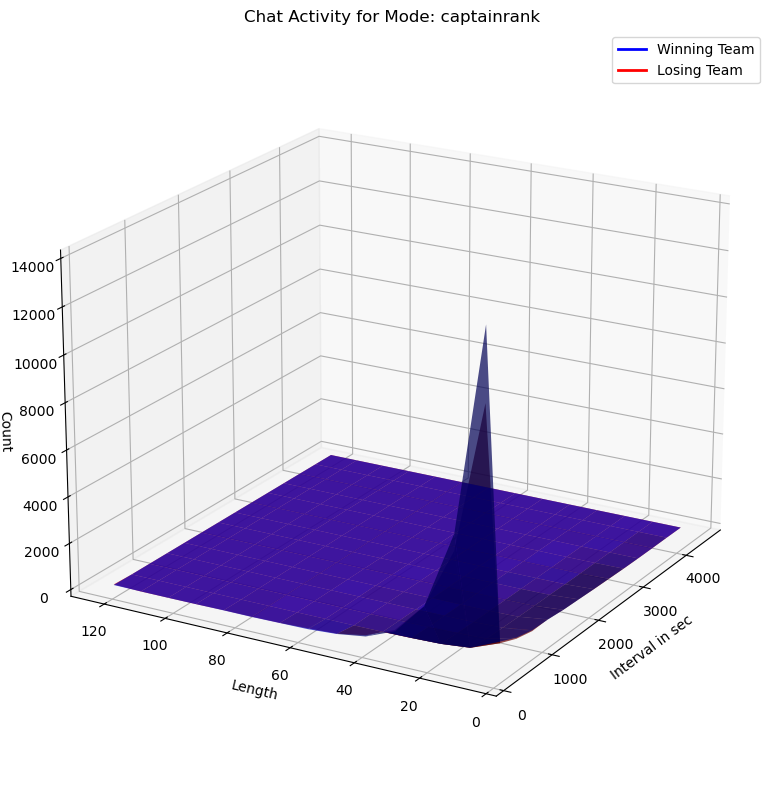

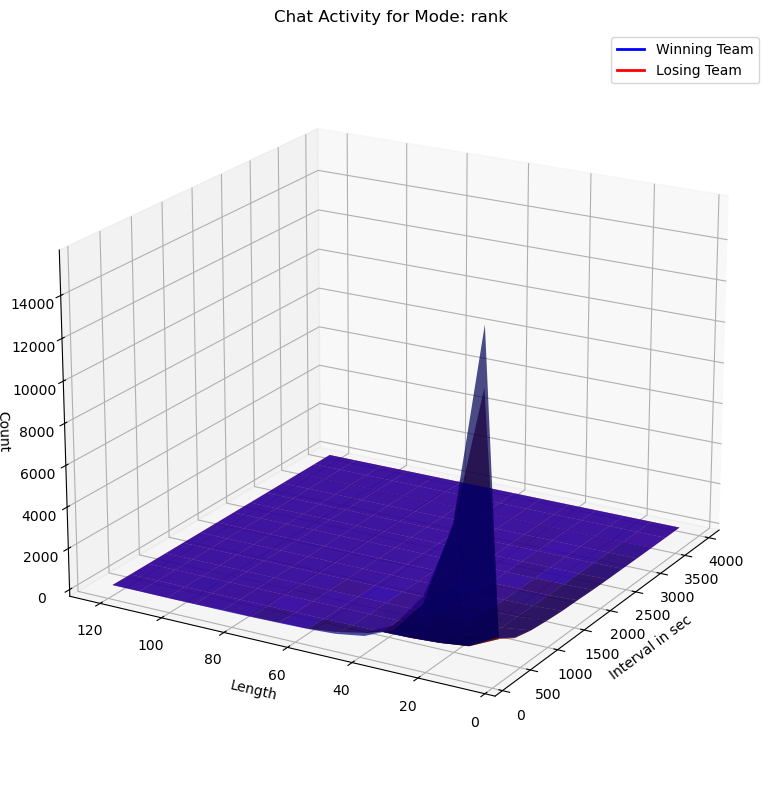

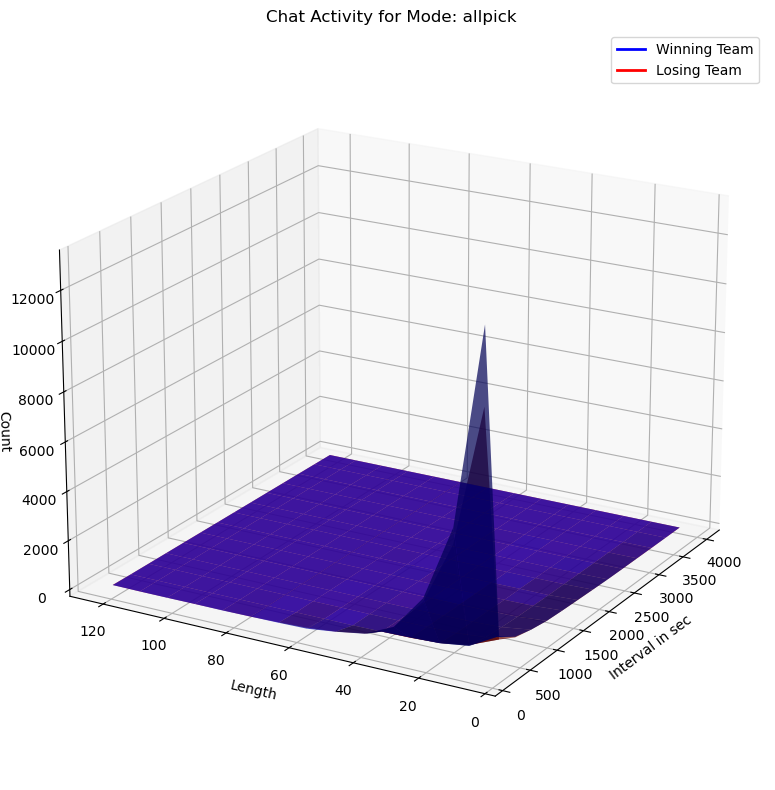

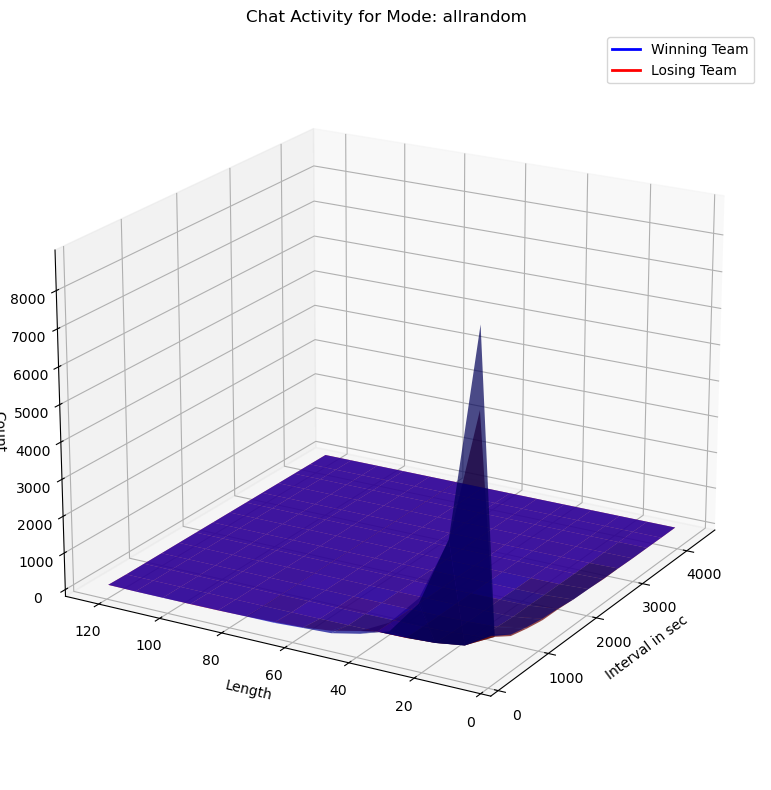

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)
    
    winning_sample = []
    losing_sample = []
    winning_L = []
    losing_L = []
    
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        wining_diff = []
        losing_diff = []
        w, l = True, True
        
        if len(obj['chat']) > 1:
            for chat in obj['chat']:
                if 'slot' in chat:
                    if (chat['slot'] in radiant and obj['radiant_win']) or (chat['slot'] in dire and not obj['radiant_win']):
                        winning_team_t.append(chat['time'])
                        if not w:
                            winning_L.append(len(str(chat['key'])))
                        w = False
                    else:
                        losing_team_t.append(chat['time'])
                        if not l:
                            losing_L.append(len(str(chat['key'])))
                        l = False
            
            if len(winning_team_t) > 1:
                wining_diff = calculate_differences(winning_team_t)
            if len(losing_team_t) > 1:
                losing_diff = calculate_differences(losing_team_t)
        
        winning_sample += wining_diff
        losing_sample += losing_diff
    
    x_bins = np.linspace(min(winning_sample + losing_sample), max(winning_sample + losing_sample), 15)
    y_bins = np.linspace(min(winning_L + losing_L), max(winning_L + losing_L), 15)
    
    winning_heatmap, xedges, yedges = np.histogram2d(winning_sample, winning_L, bins=[x_bins, y_bins])
    losing_heatmap, _, _ = np.histogram2d(losing_sample, losing_L, bins=[x_bins, y_bins])
    
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(X, Y, winning_heatmap.T, alpha=0.7, color='blue', label='Winning Team')
    ax.plot_surface(X, Y, losing_heatmap.T, alpha=0.7, color='red', label='Losing Team')
    
    ax.set_xlabel('Interval in sec')
    ax.set_ylabel('Length')
    ax.set_zlabel('Count')
    ax.set_title('Chat Activity for Mode: %s' % mode_dict[mode])
    
    # Lower the perspective for better viewing
    ax.view_init(elev=20, azim=210)  # Adjust elevation and azimuth
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', lw=2, label='Winning Team'),
        plt.Line2D([0], [0], color='red', lw=2, label='Losing Team')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
  #  plt.savefig(graph_root+'/3D_pmf_%s.pdf' % mode_dict[mode])
    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


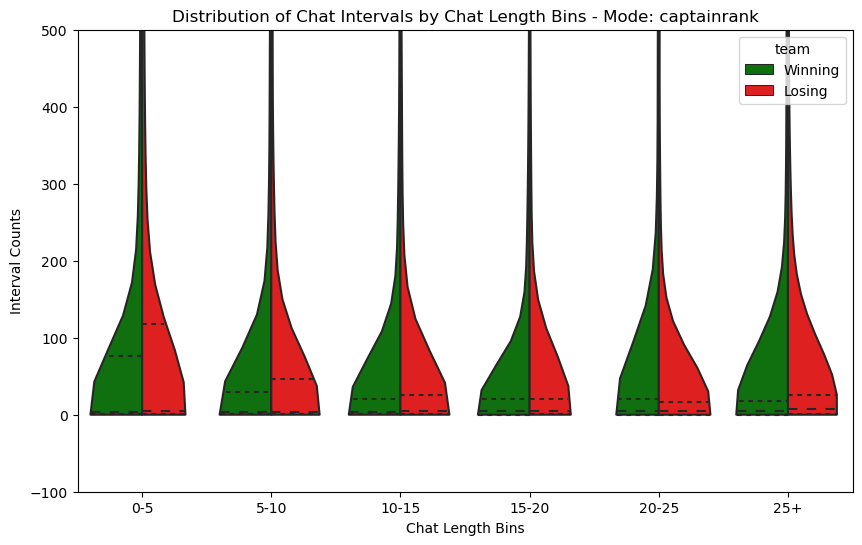

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


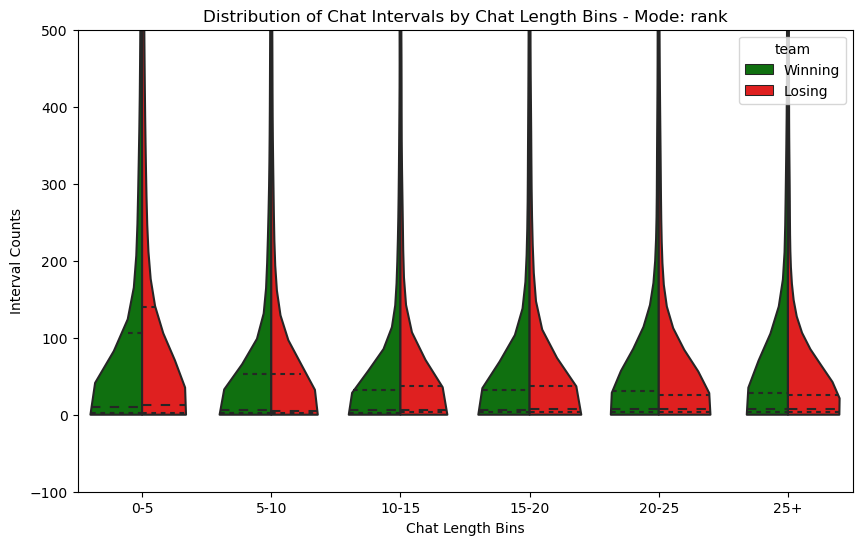

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


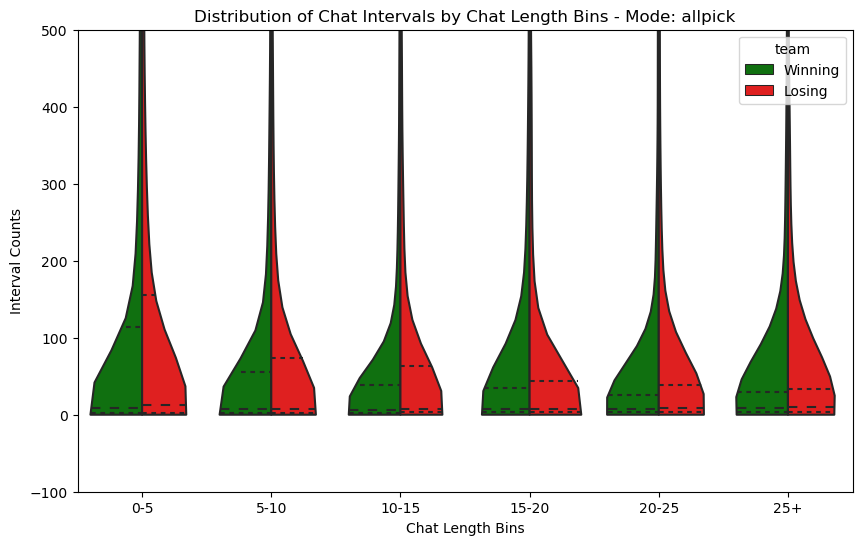

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


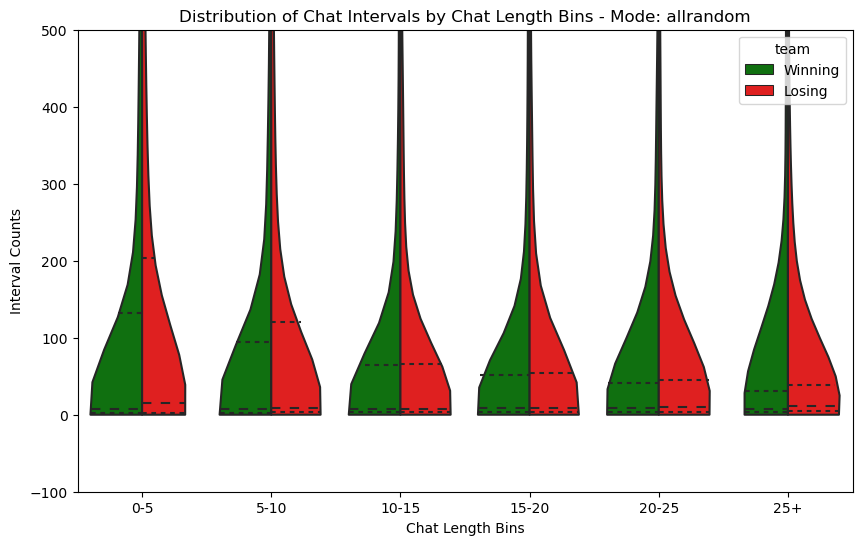

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]

for mode in modes:
    winning_sample = []
    losing_sample = []
    winning_L = []
    losing_L = []
    
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)
    
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        wining_diff = []
        losing_diff = []
        w, l = True, True
        
        if len(obj['chat']) > 1:
            for chat in obj['chat']:
                if 'slot' in chat:
                    if (chat['slot'] in radiant and obj['radiant_win']) or (chat['slot'] in dire and not obj['radiant_win']):
                        winning_team_t.append(chat['time'])
                        if not w:
                            winning_L.append(len(str(chat['key'])))
                        w = False
                    else:
                        losing_team_t.append(chat['time'])
                        if not l:
                            losing_L.append(len(str(chat['key'])))
                        l = False
            
            if len(winning_team_t) > 1:
                wining_diff = calculate_differences(winning_team_t)
            if len(losing_team_t) > 1:
                losing_diff = calculate_differences(losing_team_t)
        
        winning_sample += wining_diff
        losing_sample += losing_diff

    # Define bins for chat length
    bins = [0, 5, 10, 15, 20, 25, 30]
    labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25+']

    # Bin the winning and losing chat lengths
    winning_L_binned = pd.cut(winning_L, bins=bins, labels=labels, right=False)
    losing_L_binned = pd.cut(losing_L, bins=bins, labels=labels, right=False)

    # Create DataFrame
    
    df_winning = pd.DataFrame({'L_bin': winning_L_binned, 'interval': winning_sample, 'team': 'Winning'})
    df_losing = pd.DataFrame({'L_bin': losing_L_binned, 'interval': losing_sample, 'team': 'Losing'})
    df = pd.concat([df_winning, df_losing])

    # Compute y-axis limit (0.1% of the largest count in binned data)
    max_interval_count = max(df['interval'].max(), 1)  # Avoid zero issue
    ylim_max = max_interval_count * 1.001

    # Plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='L_bin', y='interval', hue='team', data=df, split=True, inner='quartile', palette=['green', 'red'], cut=0)

    # Labels and title
    plt.xlabel("Chat Length Bins")
    plt.ylabel("Interval Counts")
    plt.title(f"Distribution of Chat Intervals by Chat Length Bins - Mode: {mode_dict[mode]}")
    plt.ylim(-100, 500)

    # Save and show plot
    # plt.savefig(graph_root+f'/violin_plot_{mode_dict[mode]}.pdf')
    plt.show()


In [15]:
min(winning_sample)

0

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


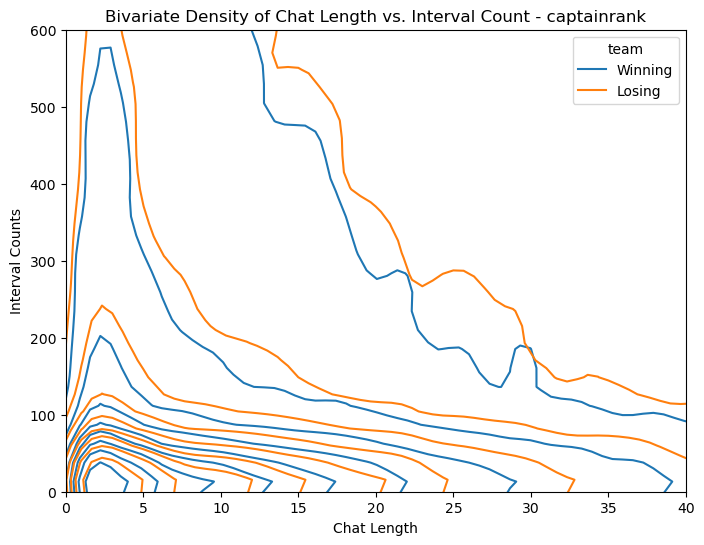

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


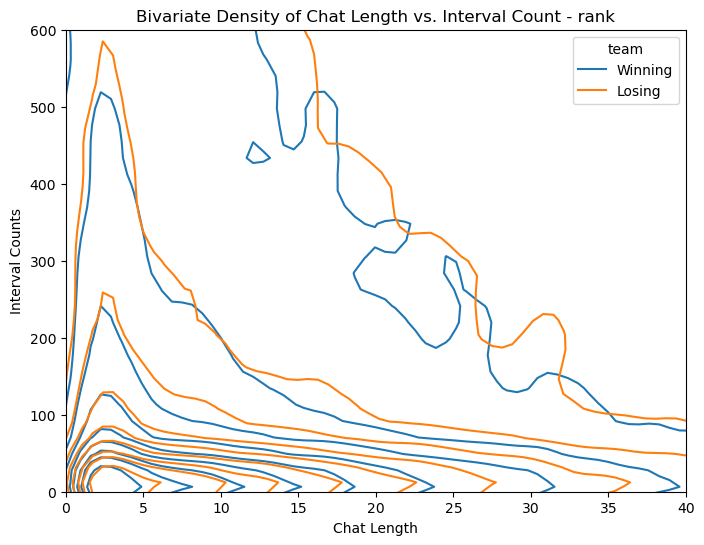

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


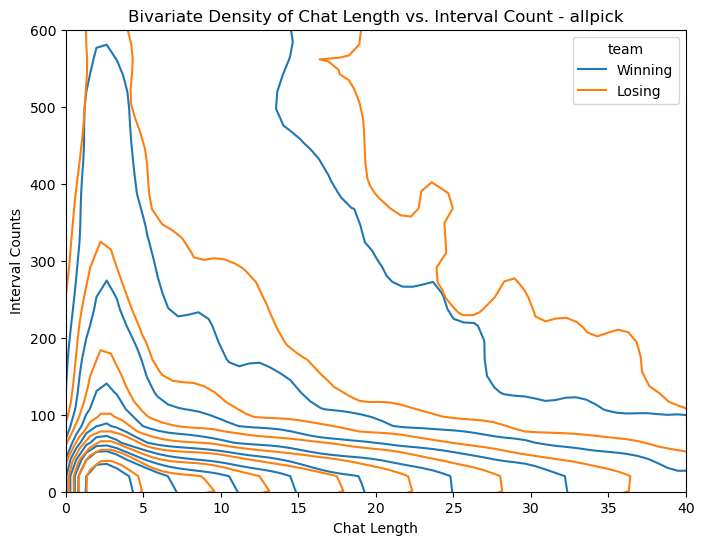

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


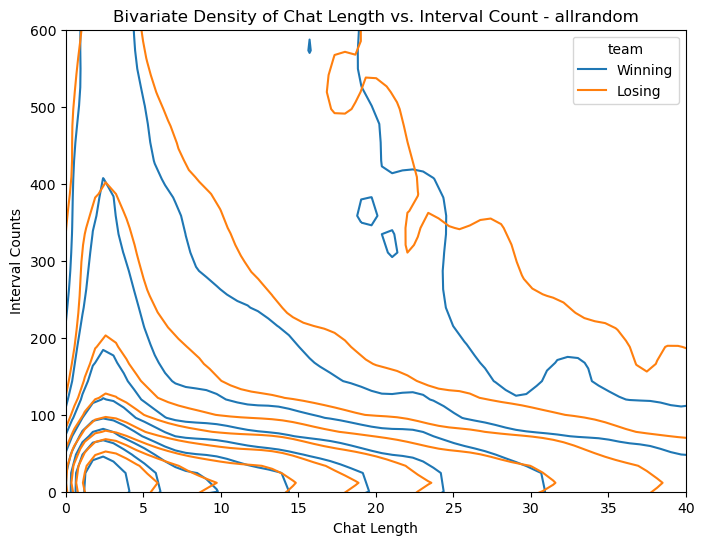

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]

for mode in modes:
    winning_sample = []
    losing_sample = []
    winning_L = []
    losing_L = []
    
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)
    
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        wining_diff = []
        losing_diff = []
        w, l = True, True
        
        if len(obj['chat']) > 1:
            for chat in obj['chat']:
                if 'slot' in chat:
                    if (chat['slot'] in radiant and obj['radiant_win']) or (chat['slot'] in dire and not obj['radiant_win']):
                        winning_team_t.append(chat['time'])
                        if not w:
                            winning_L.append(len(str(chat['key'])))
                        w = False
                    else:
                        losing_team_t.append(chat['time'])
                        if not l:
                            losing_L.append(len(str(chat['key'])))
                        l = False
            
            if len(winning_team_t) > 1:
                wining_diff = calculate_differences(winning_team_t)
            if len(losing_team_t) > 1:
                losing_diff = calculate_differences(losing_team_t)
        
        winning_sample += wining_diff
        losing_sample += losing_diff

    # Create DataFrame
    df_winning = pd.DataFrame({'L': winning_L, 'interval': winning_sample, 'team': 'Winning'})
    df_losing = pd.DataFrame({'L': losing_L, 'interval': losing_sample, 'team': 'Losing'})
    df = pd.concat([df_winning, df_losing])

    # Plot contour density for winning and losing teams on the same graph
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=df, x='L', y='interval', hue='team', fill=False, common_norm=False,bw_adjust=.5)
    
    # Labels and title
    plt.xlabel('Chat Length')
    plt.ylabel('Interval Counts')
    plt.title(f'Bivariate Density of Chat Length vs. Interval Count - {mode_dict[mode]}')
    plt.xlim(0,40)
    plt.ylim(0,600)
    # Save and show plot
   # plt.savefig(graph_root+f'/bivariate_density_{mode_dict[mode]}.pdf')
    plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


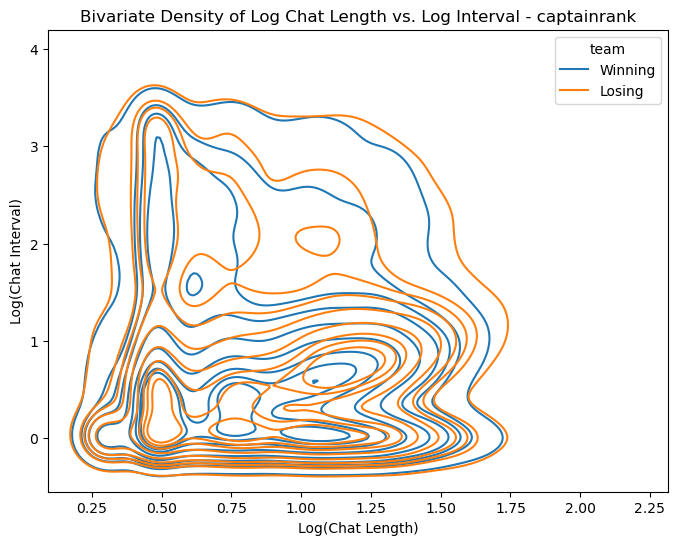

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


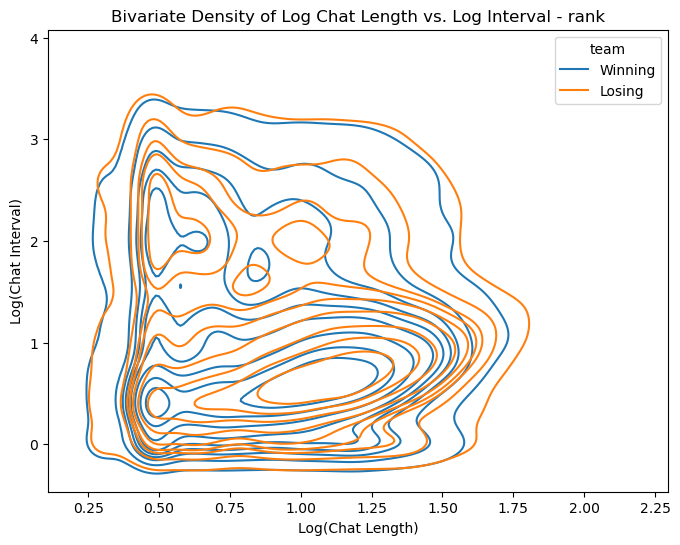

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


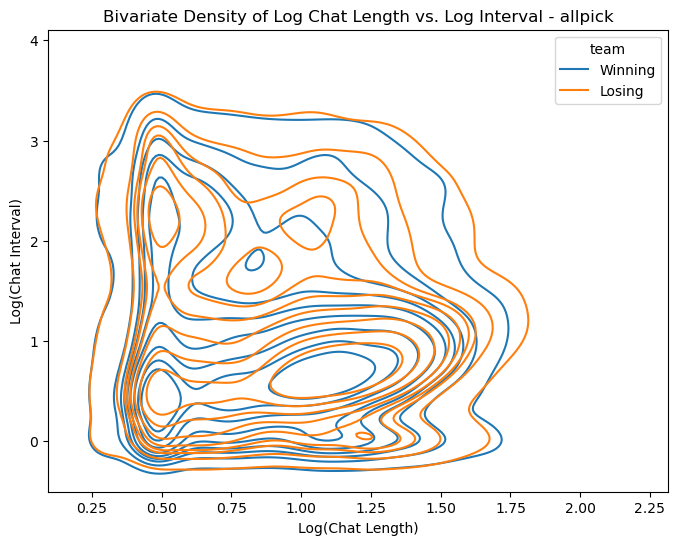

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


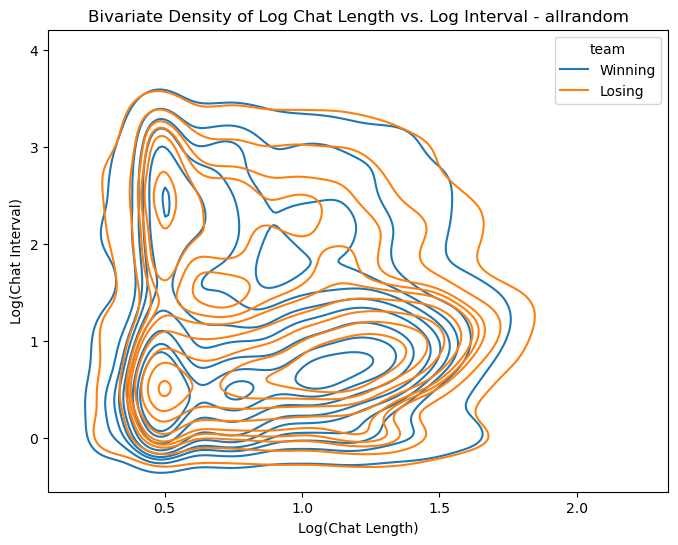

In [33]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]

for mode in modes:
    winning_sample = []
    losing_sample = []
    winning_L = []
    losing_L = []
    
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)
    
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        wining_diff = []
        losing_diff = []
        w, l = True, True
        
        if len(obj['chat']) > 1:
            for chat in obj['chat']:
                if 'slot' in chat:
                    if (chat['slot'] in radiant and obj['radiant_win']) or (chat['slot'] in dire and not obj['radiant_win']):
                        winning_team_t.append(chat['time'])
                        if not w:
                            winning_L.append(len(str(chat['key'])))
                        w = False
                    else:
                        losing_team_t.append(chat['time'])
                        if not l:
                            losing_L.append(len(str(chat['key'])))
                        l = False
            
            if len(winning_team_t) > 1:
                wining_diff = calculate_differences(winning_team_t)
            if len(losing_team_t) > 1:
                losing_diff = calculate_differences(losing_team_t)
        
        winning_sample += wining_diff
        losing_sample += losing_diff

    # Create DataFrame
    df_winning = pd.DataFrame({'L': winning_L, 'interval': winning_sample, 'team': 'Winning'})
    df_losing = pd.DataFrame({'L': losing_L, 'interval': losing_sample, 'team': 'Losing'})
    df = pd.concat([df_winning, df_losing])
    df['L'] = df['L'] + 1
    df['interval'] = df['interval'] + 1

    # Convert to log scale manually
    df['log_L'] = np.log10(df['L'])
    df['log_interval'] = np.log10(df['interval'])

    # Create the plot
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=df, x='log_L', y='log_interval', hue='team', fill=False, common_norm=False, bw_adjust=1, levels=10)

    # Properly label axes
    plt.xlabel('Log(Chat Length)')
    plt.ylabel('Log(Chat Interval)')
    plt.title(f'Bivariate Density of Log Chat Length vs. Log Interval - {mode_dict[mode]}')

    # Save and show plot
 #   plt.savefig(graph_root+f'/bivariate_density_log_{mode_dict[mode]}.pdf')
    plt.show()